# Insightly LSTM Experiment
## Author: Ronald Li


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: mps


In [2]:
# Load and explore the Amazon reviews dataset

df = pd.read_csv("amazon_reviews.csv")

print(f"Total reviews in dataset: {len(df)}")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nMissing values:")
print(f"  reviewText: {df['reviewText'].isna().sum()}")
print(f"  overall: {df['overall'].isna().sum()}")

# Remove rows with missing review text or rating
df = df.dropna(subset=["reviewText", "overall"])
print(f"\nDataset after removing missing values: {len(df)} reviews")

# Convert ratings to binary sentiment: 4-5 -> 1 (Positive), 1-3 -> 0 (Negative)
df["sentiment"] = (df["overall"] >= 4.0).astype(int)

print(f"\nRating distribution:")
print(df["overall"].value_counts().sort_index())
print(f"\nSentiment distribution:")
print(df["sentiment"].value_counts())
print(f"  Positive (1): {(df['sentiment'] == 1).sum()} ({(df['sentiment'] == 1).sum() / len(df) * 100:.1f}%)")
print(f"  Negative (0): {(df['sentiment'] == 0).sum()} ({(df['sentiment'] == 0).sum() / len(df) * 100:.1f}%)")


Total reviews in dataset: 4915

Dataset shape: (4915, 12)

Column names: ['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound']

First few rows:
   Unnamed: 0  reviewerName  overall  \
0           0           NaN      4.0   
1           1          0mie      5.0   
2           2           1K3      4.0   
3           3           1m2      5.0   
4           4  2&amp;1/2Men      5.0   

                                          reviewText  reviewTime  day_diff  \
0                                         No issues.  2014-07-23       138   
1  Purchased this for my device, it worked as adv...  2013-10-25       409   
2  it works as expected. I should have sprung for...  2012-12-23       715   
3  This think has worked out great.Had a diff. br...  2013-11-21       382   
4  Bought it with Retail Packaging, arrived legit...  2013-07-13       513   

   help

In [3]:
# Text cleaning, tokenization, and vocabulary building

def clean_text(text):
    """Clean and normalize text (lowercase, remove non-letters, collapse spaces)."""
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    text = " ".join(text.split())
    return text


def tokenize(text):
    """Split text into tokens."""
    return text.split()


df["cleaned_review"] = df["reviewText"].apply(clean_text)
df = df[df["cleaned_review"].str.len() > 0]

print(f"Dataset after cleaning: {len(df)} reviews")

# Tokenize
df["tokens"] = df["cleaned_review"].apply(tokenize)

# Build vocabulary with min frequency 2
all_words = []
for toks in df["tokens"]:
    all_words.extend(toks)

word_counts = Counter(all_words)
print(f"Total words: {len(all_words)}")
print(f"Total unique words: {len(word_counts)}")

min_word_freq = 2
filtered_word_counts = {w: c for w, c in word_counts.items() if c >= min_word_freq}
print(f"Vocabulary size after filtering (min_freq={min_word_freq}): {len(filtered_word_counts)}")

vocab = {"<PAD>": 0, "<UNK>": 1}
for word in filtered_word_counts.keys():
    vocab[word] = len(vocab)

vocab_size = len(vocab)
print(f"Final vocabulary size (including <PAD> and <UNK>): {vocab_size}")


Dataset after cleaning: 4914 reviews
Total words: 243009
Total unique words: 9826
Vocabulary size after filtering (min_freq=2): 4215
Final vocabulary size (including <PAD> and <UNK>): 4217


In [4]:
# Convert tokens to sequences of indices and pad to fixed length

def tokens_to_sequence(tokens, vocab):
    return [vocab.get(tok, vocab["<UNK>"]) for tok in tokens]


df["sequence"] = df["tokens"].apply(lambda toks: tokens_to_sequence(toks, vocab))

sequence_lengths = [len(seq) for seq in df["sequence"]]
print("Sequence length statistics:")
print("  Min:", min(sequence_lengths))
print("  Max:", max(sequence_lengths))
print("  Mean:", float(np.mean(sequence_lengths)))
print("  Median:", float(np.median(sequence_lengths)))
print("  90th percentile:", float(np.percentile(sequence_lengths, 90)))
print("  95th percentile:", float(np.percentile(sequence_lengths, 95)))

sequence_length = int(np.percentile(sequence_lengths, 95))
print(f"\nSetting fixed sequence length to: {sequence_length}")


def pad_sequence(seq, max_len, pad_value=0):
    if len(seq) >= max_len:
        return seq[:max_len]
    return seq + [pad_value] * (max_len - len(seq))


df["padded_sequence"] = df["sequence"].apply(lambda s: pad_sequence(s, sequence_length))

print(f"All sequences padded to length: {sequence_length}")


Sequence length statistics:
  Min: 1
  Max: 1515
  Mean: 49.45238095238095
  Median: 32.0
  90th percentile: 96.0
  95th percentile: 131.0

Setting fixed sequence length to: 131
All sequences padded to length: 131


In [5]:
# Build feature/label arrays and train/test split

X = np.array(df["padded_sequence"].tolist(), dtype=np.int64)
y = np.array(df["sentiment"].values, dtype=np.float32)

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print("\nTraining sentiment distribution:")
print(f"  Positive: {np.sum(y_train == 1)} ({np.sum(y_train == 1) / len(y_train) * 100:.1f}%)")
print(f"  Negative: {np.sum(y_train == 0)} ({np.sum(y_train == 0) / len(y_train) * 100:.1f}%)")
print("\nTesting sentiment distribution:")
print(f"  Positive: {np.sum(y_test == 1)} ({np.sum(y_test == 1) / len(y_test) * 100:.1f}%)")
print(f"  Negative: {np.sum(y_test == 0)} ({np.sum(y_test == 0) / len(y_test) * 100:.1f}%)")


X shape: (4914, 131)
y shape: (4914,)

Training set: 3931 samples
Testing set: 983 samples

Training sentiment distribution:
  Positive: 3558 (90.5%)
  Negative: 373 (9.5%)

Testing sentiment distribution:
  Positive: 890 (90.5%)
  Negative: 93 (9.5%)


In [6]:
# Create DataLoaders

X_train_tensor = torch.LongTensor(X_train)
X_test_tensor = torch.LongTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Batch size:", batch_size)
print("Number of training batches:", len(train_loader))
print("Number of testing batches:", len(test_loader))


Batch size: 32
Number of training batches: 123
Number of testing batches: 31


In [7]:
# Define the LSTM model (same as in rnn_lstm_sentiment_analysis.ipynb)

class SentimentLSTM(nn.Module):
    """LSTM model for binary sentiment classification (Positive vs Negative)."""

    def __init__(self, vocab_size, embedding_dim=128, hidden_size=128, num_layers=2, dropout=0.3):
        super(SentimentLSTM, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=False,
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        out, (hidden, cell) = self.lstm(embedded)
        last_output = out[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.fc(last_output)
        return logits.squeeze(-1)


modelLSTM = SentimentLSTM(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_size=128,
    num_layers=2,
    dropout=0.35,
).to(device)

print(modelLSTM)
print(f"LSTM Parameters: {sum(p.numel() for p in modelLSTM.parameters()):,}")


SentimentLSTM(
  (embedding): Embedding(4217, 128, padding_idx=0)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.35)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
LSTM Parameters: 804,097


In [8]:
# Train the LSTM with class-weighted BCEWithLogitsLoss, LR scheduler, and early stopping

num_positive = np.sum(y_train == 1)
num_negative = np.sum(y_train == 0)
pos_weight = torch.tensor([num_negative / num_positive], dtype=torch.float32).to(device)

print("Class distribution in training set:")
print(f"  Positive: {num_positive} ({num_positive/len(y_train)*100:.1f}%)")
print(f"  Negative: {num_negative} ({num_negative/len(y_train)*100:.1f}%)")
print(f"  Positive weight: {pos_weight.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(modelLSTM.parameters(), lr=1e-3)

EPOCHS = 30

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

patience = 5
best_test_loss = float("inf")
patience_counter = 0

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, verbose=True
)

max_grad_norm = 1.0

print("Starting LSTM training with improvements:")
print(f"  - Early stopping (patience={patience})")
print(f"  - Gradient clipping (max_norm={max_grad_norm})")
print("  - Learning rate scheduler (ReduceLROnPlateau)\n")

for epoch in range(1, EPOCHS + 1):
    modelLSTM.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        logits = modelLSTM(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelLSTM.parameters(), max_grad_norm)
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        train_correct += (preds == yb).sum().item()
        train_total += yb.size(0)

    avg_train_loss = train_loss / train_total
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation
    modelLSTM.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)

            logits = modelLSTM(xb)
            loss = criterion(logits, yb)

            test_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            test_correct += (preds == yb).sum().item()
            test_total += yb.size(0)

    avg_test_loss = test_loss / test_total
    test_accuracy = test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    scheduler.step(avg_test_loss)

    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
    else:
        patience_counter += 1

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
        f"Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.4f} | "
        f"Patience: {patience_counter}/{patience}"
    )

    if patience_counter >= patience:
        print(f"\nEarly stopping triggered at epoch {epoch}")
        print(f"Best test loss: {best_test_loss:.4f}")
        break

print("\nTraining completed!")

# Save model state_dict
lstm_state_path = "lstm_model_state_dict.pt"
torch.save(modelLSTM.state_dict(), lstm_state_path)
print("Saved LSTM state_dict to:", lstm_state_path)


Class distribution in training set:
  Positive: 3558 (90.5%)
  Negative: 373 (9.5%)
  Positive weight: 0.1048


/opt/homebrew/Caskroom/miniconda/base/envs/cs171/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting LSTM training with improvements:
  - Early stopping (patience=5)
  - Gradient clipping (max_norm=1.0)
  - Learning rate scheduler (ReduceLROnPlateau)

Epoch 01/30 | Train Loss: 0.1295 | Train Acc: 0.8390 | Test Loss: 0.1229 | Test Acc: 0.8942 | Patience: 0/5
Epoch 02/30 | Train Loss: 0.1251 | Train Acc: 0.8764 | Test Loss: 0.1220 | Test Acc: 0.8932 | Patience: 0/5
Epoch 03/30 | Train Loss: 0.1233 | Train Acc: 0.8733 | Test Loss: 0.1233 | Test Acc: 0.8942 | Patience: 1/5
Epoch 04/30 | Train Loss: 0.1231 | Train Acc: 0.6502 | Test Loss: 0.1199 | Test Acc: 0.8952 | Patience: 0/5
Epoch 05/30 | Train Loss: 0.1144 | Train Acc: 0.6996 | Test Loss: 0.1181 | Test Acc: 0.7040 | Patience: 0/5
Epoch 06/30 | Train Loss: 0.1060 | Train Acc: 0.7721 | Test Loss: 0.1191 | Test Acc: 0.8271 | Patience: 1/5
Epoch 07/30 | Train Loss: 0.0913 | Train Acc: 0.8156 | Test Loss: 0.1272 | Test Acc: 0.8454 | Patience: 2/5
Epoch 08/30 | Train Loss: 0.0918 | Train Acc: 0.8387 | Test Loss: 0.1161 | Test Acc:

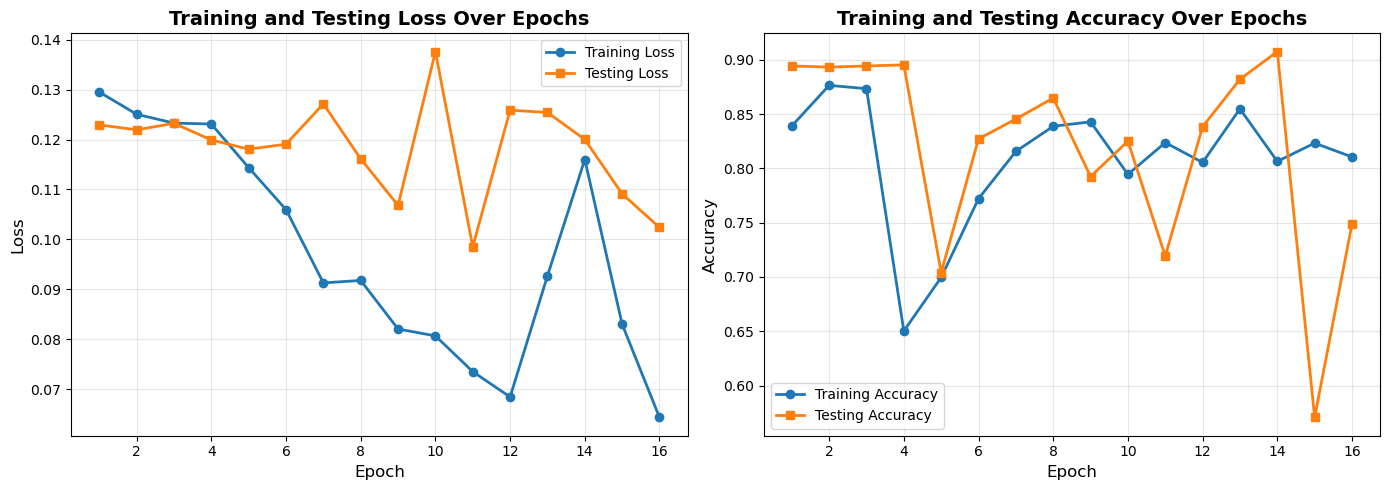


Final Results:
  Epochs trained: 16
  Best Training Accuracy: 0.8764
  Best Testing Accuracy: 0.9074


In [ ]:
# Visualize training and testing loss/accuracy over epochs

epochs_trained = len(train_losses)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, epochs_trained + 1), train_losses, "o-", label="Training Loss", linewidth=2)
ax1.plot(range(1, epochs_trained + 1), test_losses, "s-", label="Testing Loss", linewidth=2)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Training and Testing Loss Over Epochs", fontsize=14, fontweight="bold")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, epochs_trained + 1), train_accuracies, "o-", label="Training Accuracy", linewidth=2)
ax2.plot(range(1, epochs_trained + 1), test_accuracies, "s-", label="Testing Accuracy", linewidth=2)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy", fontsize=12)
ax2.set_title("Training and Testing Accuracy Over Epochs", fontsize=14, fontweight="bold")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nFinal Results:")
print(f"  Epochs trained: {epochs_trained}")
print(f"  Best Training Accuracy: {max(train_accuracies):.4f}")
print(f"  Best Testing Accuracy: {max(test_accuracies):.4f}")


In [10]:
# Helper for predicting sentiment on raw text + tests on custom reviews

def predict_sentiment(review_text, model, vocab, sequence_length, device):
    """Predict sentiment ('Positive' or 'Negative') for a single review."""
    model.eval()

    cleaned = clean_text(review_text)
    tokens = tokenize(cleaned)
    sequence = tokens_to_sequence(tokens, vocab)
    padded = pad_sequence(sequence, sequence_length)

    input_tensor = torch.LongTensor([padded]).to(device)

    with torch.no_grad():
        logits = model(input_tensor)
        prob_pos = torch.sigmoid(logits).item()

    sentiment = "Positive" if prob_pos >= 0.5 else "Negative"

    # Rough 1–5 rating estimate based on probability
    if sentiment == "Positive":
        rating = 4 + (prob_pos - 0.5) * 2  # 0.5–1.0 -> 4–5
    else:
        rating = 1 + prob_pos * 4          # 0.0–0.5 -> 1–3

    return sentiment, prob_pos, rating


print("=" * 80)
print("PREDICTIONS ON NEW CUSTOM REVIEWS")
print("=" * 80)

custom_reviews = [
    "This product is absolutely amazing! Best purchase I've ever made. Highly recommend!",
    "Terrible quality. Broke after one day. Complete waste of money.",
    "It's okay, nothing special. Does what it's supposed to do.",
    "Love it! Exactly what I needed. Fast shipping and great quality.",
    "Do not buy this! Very disappointed with the quality and performance.",
    "Decent product for the price. Works as expected.",
]

for review in custom_reviews:
    sentiment, confidence, rating = predict_sentiment(
        review, modelLSTM, vocab, sequence_length, device
    )
    print(f"\nReview: {review}")
    print(f"Predicted: {sentiment} | Confidence: {confidence:.4f} | Est. Rating: {rating:.2f}/5.0")
    print("-" * 80)


PREDICTIONS ON NEW CUSTOM REVIEWS

Review: This product is absolutely amazing! Best purchase I've ever made. Highly recommend!
Predicted: Positive | Confidence: 0.9598 | Est. Rating: 4.92/5.0
--------------------------------------------------------------------------------

Review: Terrible quality. Broke after one day. Complete waste of money.
Predicted: Negative | Confidence: 0.1609 | Est. Rating: 1.64/5.0
--------------------------------------------------------------------------------

Review: It's okay, nothing special. Does what it's supposed to do.
Predicted: Positive | Confidence: 0.9598 | Est. Rating: 4.92/5.0
--------------------------------------------------------------------------------

Review: Love it! Exactly what I needed. Fast shipping and great quality.
Predicted: Positive | Confidence: 0.9598 | Est. Rating: 4.92/5.0
--------------------------------------------------------------------------------

Review: Do not buy this! Very disappointed with the quality and performan